In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import datetime
import cv2

np.random.seed(42)
tf.random.set_seed(42)

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

2021-12-05 12:51:37.135193: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
# lists possible devices (CPU, GPU)
# used to check if GPU is recognized/exists
tf.config.get_visible_devices()


2021-12-05 12:51:44.970427: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-12-05 12:51:44.971233: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-12-05 12:51:45.162158: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-05 12:51:45.162351: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1080 computeCapability: 6.1
coreClock: 1.8225GHz coreCount: 20 deviceMemorySize: 7.93GiB deviceMemoryBandwidth: 298.32GiB/s
2021-12-05 12:51:45.162378: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-12-05 12:51:45.167871: I tensorflow/stream_executor/platform/d

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# preprocessing of the images applied when loading image data set from disk with
# tensorflows flow_from_directory

image_gen = keras.preprocessing.image.ImageDataGenerator(rotation_range=20,  # rotate the image 20 degrees
                                                         width_shift_range=0.2,
                                                         height_shift_range=0.2,
                                                         rescale=1 / 255,  # Rescale the image by normalzing it.
                                                         shear_range=0.15,
                                                         # Shear means cutting away part of the image (max 20%)
                                                         zoom_range=0.15,  # Zoom in by 15% max
                                                         horizontal_flip=True,  # Allow horizontal flipping
                                                         fill_mode='nearest'
                                                         # Fill in missing pixels with the nearest filled value
                                                         )

In [33]:
# path to the image data set

#train_data_path = './drive/MyDrive/Bachelor/data_balanced/train' #google colab
#test_data_path = './drive/MyDrive/Bachelor/data_balanced/test' #google colab
#validation_data_path = './drive/MyDrive/Bachelor/data_balanced/validation' #google colab
train_data_path = './data/data_heavily_reduced/data_balanced/train'  #local notebook
test_data_path = './data/data_heavily_reduced/data_balanced/test'  #local notebook
validation_data_path = './data/data_heavily_reduced/data_balanced/val'  #local notebook


In [34]:
# generate training set by loading the images from their directories with flow_from_directory
# important: the folder structure has to match! i.e {train} -> {ok,def}
# at the "same time" the data augmentation is applied on the images through the ImageDataGenerator

train_image_gen = image_gen.flow_from_directory(train_data_path,
                                                target_size=(224, 224),
                                                class_mode='binary')

Found 7999 images belonging to 2 classes.


In [35]:
# generate test set by loading the images from their directories with flow_from_directory
# important: the folder structure has to match! i.e {test} -> {ok,def}
# at the "same time" the data augmentation is applied on the images through the ImageDataGenerator

test_image_gen = image_gen.flow_from_directory(test_data_path,
                                               target_size=(224, 224),
                                               class_mode='binary')

Found 1001 images belonging to 2 classes.


In [36]:
# generate validation set by loading the images from their directories with flow_from_directory
# important: the folder structure has to match! i.e {validation} -> {ok,def}
# at the "same time" the data augmentation is applied on the images through the ImageDataGenerator

valid_set = image_gen.flow_from_directory(validation_data_path,
                                          target_size=(224, 224),
                                          class_mode='binary')

Found 999 images belonging to 2 classes.


In [4]:
# saves the model and its weights as a json file in the folder saved_models

def save_model(model, model_name):
    my_model = model.to_json()
    with open(f'./saved_models/{model_name}.json', "w") as file:
        file.write(my_model)
    # serialize weights to HDF5
    model.save_weights(f'./saved_models/{model_name}_weights.h5')

In [5]:
#TODO: load model no compiling ?

def load_model(model_path, weight_path):
  # load json and create model
   file = open(model_path, 'r')
   model_json = file.read()
   file.close()
   loaded_model = keras.models.model_from_json(model_json)
   # load weights
   loaded_model.load_weights(weight_path)
   optimizer = keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999)
   loaded_model.compile(loss="binary_crossentropy", optimizer=optimizer,
                        metrics=['accuracy', 'Recall', 'Precision', 'AUC'])
   return loaded_model

In [6]:
# method to select the base model architecture
# pretrained with the weights of the imagenet data set
# the top layers are excluded and have to be implemented on top of the base model
# currently Vgg16, Xception, ResNet50

def build_base_model(model_selected, weights):
    if model_selected == 'vgg':
        return keras.applications.vgg16.VGG16(include_top=False, weights=weights)
    if model_selected == 'xception':
        return keras.applications.xception.Xception(include_top=False, weights=weights)
    if model_selected == 'resnet':
        return keras.applications.resnet50.ResNet50(include_top=False, weights=weights)

In [7]:
# method which adds the new top layers on the base model and returns the now complete model

def model_builder(input_model):
    model_input = keras.Input(shape=(224, 224, 3), name='image_input')

    output_base_model = input_model(model_input)

    x = keras.layers.Flatten(name='flatten')(output_base_model)
    x = keras.layers.Dense(1000)(x)
    x = keras.layers.Dropout(0.25)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dense(1, activation='sigmoid')(x)

    return keras.models.Model(model_input, x)

In [8]:
# method activate the base models layers ability to learn (be trainable)
# set to false for the first training run to not destroy the pretrained weights

def set_layers_trainable(trainable, input_model):
    for layer in input_model.layers:
        layer.trainable = trainable

In [9]:
# method to compile the model with the adam optimizer which returns the compiled model

def compile_model(input_model, alpha, beta1, beta2, metrics):
    optimizer = keras.optimizers.Adam(learning_rate=alpha, beta_1=beta1, beta_2=beta2)
    model = model_builder(input_model)
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=metrics)

    return model

In [10]:
# method to train the model

def train_model(input_model, train_set, test_set, epochs, callback):
    return input_model.fit(train_set,
                     validation_data=test_set,
                     epochs=epochs,
                     callbacks=callback)


In [43]:
# Script which uses
# vgg16 as a base model
# the adams optimizer with learning rate: 0.0001, beta_1: 0.9 and beta_2: 0.99
# accuracy, recall, precision, auc as metrics
# trains the frozen model for 5 epochs
# defines an early stopping callback with an patience of 20
# trains the unfrozen model (for 100 epoch) till early stopping stops the training
# and prints the values of the metrics


# set base model
vgg16_base_model = build_base_model('vgg', 'imagenet')

# freeze layers of base model for first train run
set_layers_trainable(False, vgg16_base_model)

# compile model (also builds the model)
vgg16_model = compile_model(vgg16_base_model,0.0001, 0.9, 0.999, ['accuracy', 'Recall', 'Precision', 'AUC'])

# train frozen layer model
history = train_model(vgg16_model, train_image_gen, test_image_gen, 5, [])



Epoch 1/5
134/250 [===============>..............] - ETA: 30s - loss: 0.4560 - accuracy: 0.8222 - recall: 0.8270 - precision: 0.8138 - auc: 0.8905

2021-12-05 10:11:17.749141: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.35GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


250/250 [==============================] - 94s 373ms/step - loss: 0.3861 - accuracy: 0.8516 - recall: 0.8525 - precision: 0.8481 - auc: 0.9179 - val_loss: 0.1747 - val_accuracy: 0.9311 - val_recall: 0.8942 - val_precision: 0.9655 - val_auc: 0.9845
Epoch 2/5
250/250 [==============================] - 89s 356ms/step - loss: 0.2068 - accuracy: 0.9241 - recall: 0.9221 - precision: 0.9274 - auc: 0.9758 - val_loss: 0.1023 - val_accuracy: 0.9560 - val_recall: 0.9641 - val_precision: 0.9489 - val_auc: 0.9937
Epoch 3/5
250/250 [==============================] - 88s 353ms/step - loss: 0.1717 - accuracy: 0.9392 - recall: 0.9397 - precision: 0.9385 - auc: 0.9821 - val_loss: 0.1183 - val_accuracy: 0.9600 - val_recall: 1.0000 - val_precision: 0.9261 - val_auc: 0.9938
Epoch 4/5
250/250 [==============================] - 91s 362ms/step - loss: 0.1526 - accuracy: 0.9425 - recall: 0.9441 - precision: 0.9421 - auc: 0.9857 - val_loss: 0.1422 - val_accuracy: 0.9411 - val_recall: 0.8942 - val_precision: 0.9

In [17]:
#save_model(vgg16_model, 'vgg16_5Epoch_frozen_train')

In [44]:
# unfreeze base model layers
set_layers_trainable(True, vgg16_base_model)

# compile model
vgg16_model = compile_model(vgg16_base_model,0.0001, 0.9, 0.999, ['accuracy', 'Recall', 'Precision', 'AUC'])

# define callback
custom_early_stopping = keras.callbacks.EarlyStopping(patience=20)

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")

2021-12-05 10:21:33.201083: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-12-05 10:21:33.201117: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2021-12-05 10:21:33.201174: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2021-12-05 10:21:33.201191: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.


In [45]:
# train complete model
history = train_model(vgg16_model, train_image_gen, test_image_gen, 100, [custom_early_stopping, tensorboard_callback])


Epoch 1/100
  1/250 [..............................] - ETA: 8:40 - loss: 0.8202 - accuracy: 0.5000 - recall: 0.5294 - precision: 0.5294 - auc: 0.5490

2021-12-05 10:21:39.622404: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-12-05 10:21:39.622456: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2021-12-05 10:21:39.622534: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED


  2/250 [..............................] - ETA: 2:10 - loss: 0.8202 - accuracy: 0.5156 - recall: 0.5441 - precision: 0.5441 - auc: 0.5782

2021-12-05 10:21:40.334105: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2021-12-05 10:21:40.339506: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 0 callback api events and 0 activity events. 
2021-12-05 10:21:40.360419: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2021-12-05 10:21:40.362777: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: ./logs/train/plugins/profile/2021_12_05_10_21_40
2021-12-05 10:21:40.363627: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to ./logs/train/plugins/profile/2021_12_05_10_21_40/pop-os.trace.json.gz
2021-12-05 10:21:40.390678: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: ./logs/train/plugins/profile/2021_12_05_10_21_40
2021-12-05 10:21:40.394840: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped

 35/250 [===>..........................] - ETA: 1:20 - loss: 0.5919 - accuracy: 0.7348 - recall: 0.7350 - precision: 0.7199 - auc: 0.8156

2021-12-05 10:21:58.367026: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.01GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


250/250 [==============================] - 110s 434ms/step - loss: 0.3679 - accuracy: 0.8446 - recall: 0.8461 - precision: 0.8379 - auc: 0.9243 - val_loss: 0.1307 - val_accuracy: 0.9530 - val_recall: 0.9880 - val_precision: 0.9235 - val_auc: 0.9911
Epoch 2/100
250/250 [==============================] - 97s 387ms/step - loss: 0.1335 - accuracy: 0.9484 - recall: 0.9507 - precision: 0.9472 - auc: 0.9888 - val_loss: 0.0840 - val_accuracy: 0.9730 - val_recall: 0.9461 - val_precision: 1.0000 - val_auc: 0.9980
Epoch 3/100
250/250 [==============================] - 97s 387ms/step - loss: 0.1284 - accuracy: 0.9503 - recall: 0.9551 - precision: 0.9448 - auc: 0.9897 - val_loss: 0.1014 - val_accuracy: 0.9660 - val_recall: 0.9980 - val_precision: 0.9381 - val_auc: 0.9981
Epoch 4/100
250/250 [==============================] - 98s 391ms/step - loss: 0.0892 - accuracy: 0.9623 - recall: 0.9659 - precision: 0.9607 - auc: 0.9945 - val_loss: 0.3044 - val_accuracy: 0.9121 - val_recall: 1.0000 - val_precisi

In [46]:

# metrics from the paper:
# accuracy = 0.959, precision = 0.939, recall = 0.980, f1-score = 0.959, auc value = 0.982
loss, accuracy, recall, precision, auc = vgg16_model.evaluate(valid_set)



32/32 [==============================] - 13s 419ms/step - loss: 8.1372e-04 - accuracy: 1.0000 - recall: 1.0000 - precision: 1.0000 - auc: 1.0000


In [48]:
# F1 score
f1 = 2 * ((precision * recall) / (precision + recall))

print(f"loss: {loss}, \n"
      f"accuracy: {accuracy}, \n"
      f"recall: {recall}, \n"
      f"precision: {precision}, \n"
      f"auc: {auc}, \n"
      f"F1: {f1}")

loss: 0.0008137187105603516, 
accuracy: 1.0, 
recall: 1.0, 
precision: 1.0, 
auc: 1.0, 
F1: 1.0


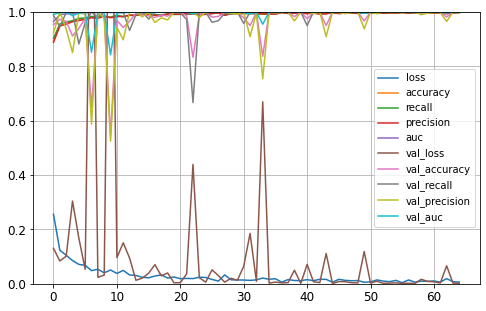

In [49]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)  # set the vertical range to [0-1]
plt.show()


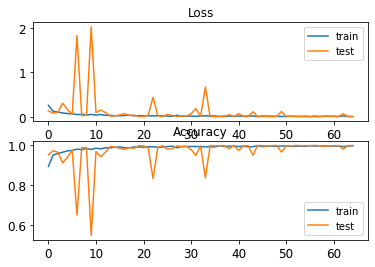

In [50]:
# plot loss during training
plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [51]:
# uses the save_model method to save the model and its weights to the hard drive
save_model(vgg16_model, 'vgg16_heavily_reduced_data')

In [52]:
%tensorboard --logdir logs/fit

UsageError: Line magic function `%tensorboard` not found.


In [ ]:
# original = cv2.imread('random-img.jpg')
# rgb = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
# img = cv2.resize(rgb,(224,224)) / 255
# plt.imshow(img)
# img.shape
#
# images = np.array([img])
# height, width, channels = image.shape

In [ ]:
inputs = keras.applications.vgg16.preprocess_input(images * 255)

In [ ]:
# metrics from the paper:
# accuracy = 0.959, precision = 0.939, recall = 0.980, f1-score = 0.959, auc value = 0.982
loss, accuracy, recall, precision, auc = full_model.evaluate(valid_set)
# F1 score
f1 = 2 * ((precision * recall) / (precision + recall))

print(f"loss: {loss}, \n"
      f"accuracy: {accuracy}, \n"
      f"recall: {recall}, \n"
      f"precision: {precision}, \n"
      f"auc: {auc}, \n"
      f"F1: {f1}")

In [ ]:
# metrics from the paper:
# accuracy = 0.959, precision = 0.939, recall = 0.980, f1-score = 0.959, auc value = 0.982
loss, accuracy, recall, precision, auc = heavy_reduced_model.evaluate(valid_set)
# F1 score
f1 = 2 * ((precision * recall) / (precision + recall))

print(f"loss: {loss}, \n"
      f"accuracy: {accuracy}, \n"
      f"recall: {recall}, \n"
      f"precision: {precision}, \n"
      f"auc: {auc}, \n"
      f"F1: {f1}")